In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from filt_plot_funcs import *


In [2]:
fs = 200

## DAQ

### Low Pass Filter

In [3]:
b, a = signal.iirfilter(N = 4, Wn = 40, btype="lowpass", ftype='butter', fs=fs)
b = np.single(b)
a = np.single(a)

print(f"b = {b}\na = {a}")


b = [0.04658291 0.18633163 0.27949744 0.18633163 0.04658291]
a = [ 1.         -0.7820952   0.67997855 -0.1826757   0.03011888]


In [4]:
sos = signal.tf2sos(b, a).astype(dtype=np.float16)

print(f"Unformatted:\n{sos}")
print(f"\nFormatted:", end='')
for section_num in range(np.shape(sos)[0]):
    print("\n")
    for coeff in range(np.shape(sos)[1]):
        print(sos[section_num][coeff], end=", ")

Unformatted:
[[ 0.04657  0.09314  0.04657  1.      -0.3289   0.0646 ]
 [ 1.       2.       1.       1.      -0.4531   0.4663 ]]

Formatted:

0.04657, 0.09314, 0.04657, 1.0, -0.3289, 0.0646, 

1.0, 2.0, 1.0, 1.0, -0.4531, 0.4663, 

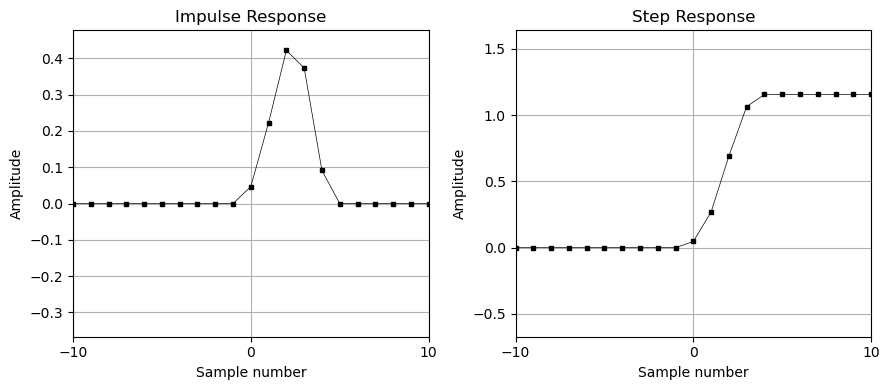

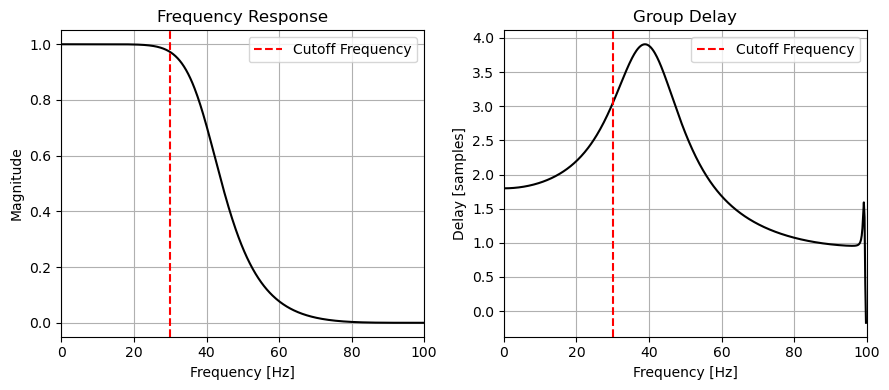

<Figure size 640x480 with 0 Axes>

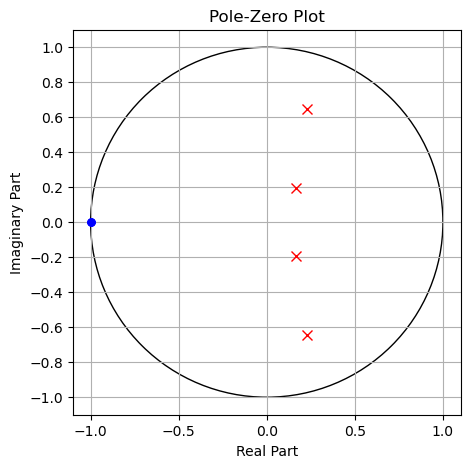

In [5]:
plot_domain_t(b, a)

_, [ax1, ax2] = plt.subplots(1, 2, figsize=[9, 4], tight_layout=True)

plot_domain_f(b, a, fs=fs, ax1=ax1, ax2=ax2)

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.axvline(x=30, linestyle='dashed', color='r', label="Cutoff Frequency")
    plt.legend()
    
plot_pole_zero(b, a)

### IIR Notch Filter (1)

In [6]:
sos = np.float32(signal.iirfilter(N=2, Wn= [59,61], btype="bandstop", ftype="butter", fs=fs, output='sos'))
sos2 = np.delete(sos, 3, 1).flatten()

print("{")
for n in range(len(sos2)):
    endOfStr = ",\n" if ((n + 1) < len(sos2)) else "\n};"
    print((" " * 4) + f"(float32_t) {sos2[n]}", end=endOfStr)
    

{
    (float32_t) 0.9565432071685791,
    (float32_t) 0.591468095779419,
    (float32_t) 0.9565432071685791,
    (float32_t) 0.5631667971611023,
    (float32_t) 0.9562366008758545,
    (float32_t) 1.0,
    (float32_t) 0.6183391213417053,
    (float32_t) 1.0,
    (float32_t) 0.6460562348365784,
    (float32_t) 0.9568508863449097
};

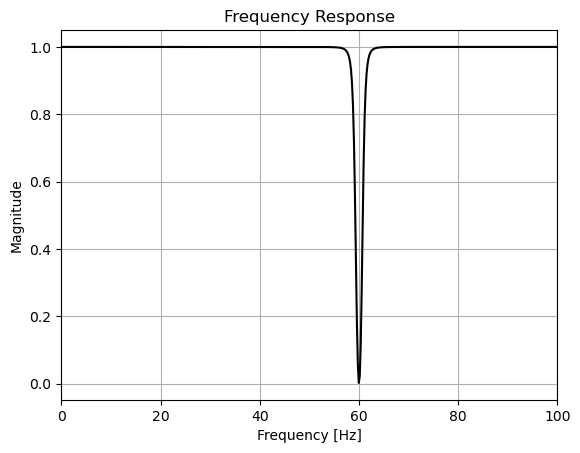

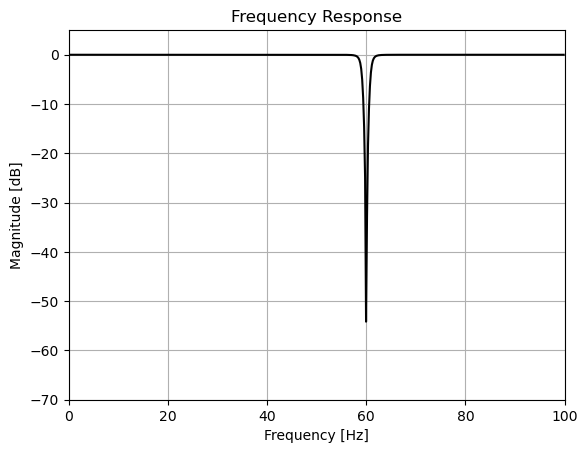

<Figure size 640x480 with 0 Axes>

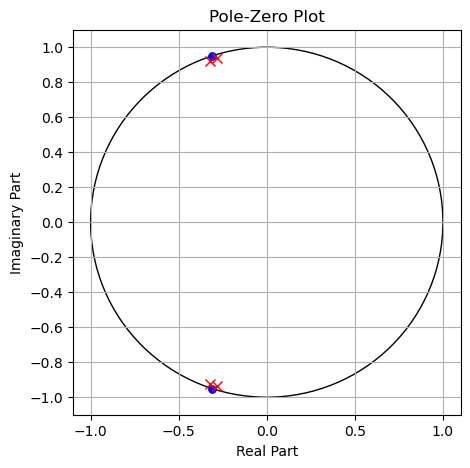

In [7]:
b, a = signal.sos2tf(np.float32(sos))

plot_freq_resp(b, a, fs=200, in_dB=False)

plot_freq_resp(b, a, fs=200, in_dB=True)
plt.ylim([-70, 5]);

plot_pole_zero(b, a)


### IIR Notch Filter (2)

b = [0.7547627  0.46646902 0.7547627 ]
a = [1.         0.46646902 0.5095255 ]
z = [-0.309017+0.95105654j -0.309017-0.95105654j]
p = [-0.23323451+0.6746311j -0.23323451-0.6746311j] -> abs(p) = [0.7138105 0.7138105]
k = 0.7547627091407776


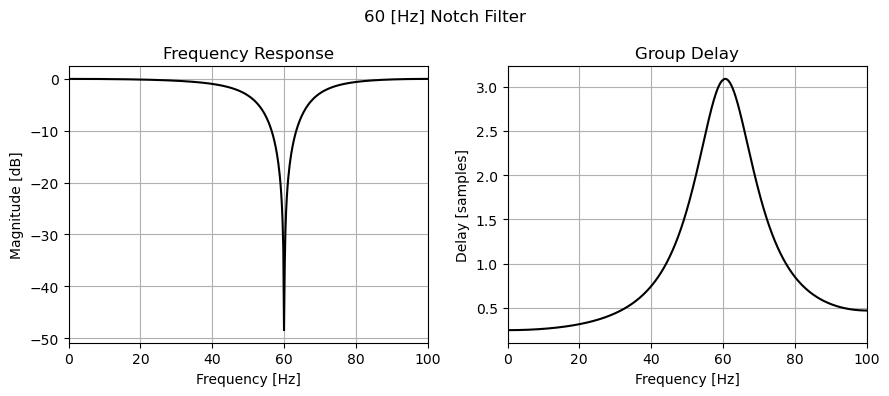

<Figure size 640x480 with 0 Axes>

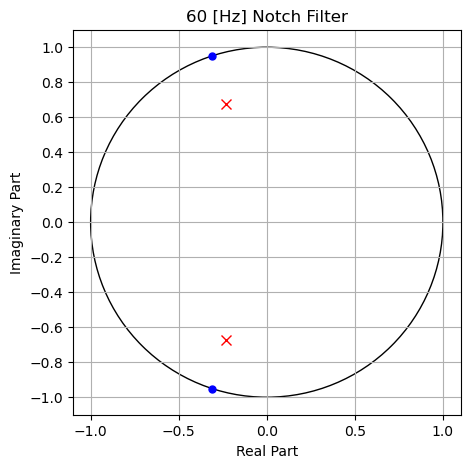

In [9]:
(b, a) = np.float32(signal.iirnotch(60, 3, fs=fs))
print(f"b = {b}")
print(f"a = {a}")

z, p, k = signal.tf2zpk(b, a)
print(f"z = {z}")
print(f"p = {p} -> abs(p) = {np.abs(p)}")
print(f"k = {k}")

plot_domain_f(b, a, fs=fs, in_dB=True, filt_name="60 [Hz] Notch Filter")
plot_pole_zero(b, a, filt_name="60 [Hz] Notch Filter")

## QRS

### QRS LPF

In [ ]:
b, a = signal.iirfilter(N=2, Wn=20, btype='lowpass', ftype='butter', fs=fs)
b = np.single(b)
a = np.single(a)

print(f"b = {b}\na = {a}")


In [ ]:
sos = signal.tf2sos(b, a).astype(dtype=np.float16)

print(f"Unformatted:\n{sos}")
print(f"\nFormatted:", end='')
for section_num in range(np.shape(sos)[0]):
    print("\n")
    for coeff in range(np.shape(sos)[1]):
        print(sos[section_num][coeff], end=", ")

In [ ]:
plot_domain_t(b, a)

_, [ax1, ax2] = plt.subplots(1, 2, figsize=[9, 4], tight_layout=True)

plot_domain_f(b, a, fs=fs, ax1=ax1, ax2=ax2)

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.axvline(x=30, linestyle='dashed', color='r', label="Cutoff Frequency")
    plt.legend()
    
plot_pole_zero(b, a)

### QRS HPF

In [ ]:
b, a = signal.iirfilter(N=2, Wn=12, btype='highpass', ftype='butter', fs=fs)
b = np.single(b)
a = np.single(a)

print(f"b = {b}\na = {a}")


In [ ]:
sos = signal.tf2sos(b, a).astype(dtype=np.float16)

print(f"Unformatted:\n{sos}")
print(f"\nFormatted:", end='')
for section_num in range(np.shape(sos)[0]):
    print("\n")
    for coeff in range(np.shape(sos)[1]):
        print(sos[section_num][coeff], end=", ")

In [ ]:
plot_domain_t(b, a)

_, [ax1, ax2] = plt.subplots(1, 2, figsize=[9, 4], tight_layout=True)

plot_domain_f(b, a, fs=fs, ax1=ax1, ax2=ax2)

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.axvline(x=30, linestyle='dashed', color='r', label="Cutoff Frequency")
    plt.legend()
    
plot_pole_zero(b, a)

### QRS Derivative Filter

In [ ]:
b = np.array( [1, 2, 0, -2, -1] ) / 8
a = np.zeros(np.shape(b))
a[0] = 1

b = np.single(b)
a = np.single(a)

print(f"b = {b}\na = {a}")

In [ ]:
plot_domain_t(b, a)

_, [ax1, ax2] = plt.subplots(1, 2, figsize=[9, 4], tight_layout=True)

plot_domain_f(b, a, fs=fs, ax1=ax1, ax2=ax2)

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.axvline(x=30, linestyle='dashed', color='r', label="Cutoff Frequency")
    plt.legend()
    
plot_pole_zero(b, a)

### QRS MA Filter

In [ ]:
M = 15
b = np.ones(M) / M
a = np.zeros(np.shape(b))
a[0] = 1

b = np.single(b)
a = np.single(a)

print(f"b = {b}\na = {a}")

In [ ]:
plot_domain_t(b, a)

_, [ax1, ax2] = plt.subplots(1, 2, figsize=[9, 4], tight_layout=True)

plot_domain_f(b, a, fs=fs, ax1=ax1, ax2=ax2)

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.axvline(x=30, linestyle='dashed', color='r', label="Cutoff Frequency")
    plt.legend()
    
plot_pole_zero(b, a)